In [1]:
from data import Data
from dimension_reduction import PCADimensionReduction
from simple_ml_models import *
from utils import *
from additional_test_set_visualisation import Visualisation

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import svm
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


2023-02-27 18:27:00.397331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_filepath = "data/SC_integration/counts_ctc_simulated_123_5k.tsv"
true_results_filepath = "data/SC_integration/ids_ctc_simulated_123_5k.tsv"
train_indices_filepath = "data/SC_integration/train_indices.npy"
test_indices_filepath = "data/SC_integration/test_indices.npy"
SEED = 42
FOLD_NUMBER = 3



# There are 4 data variants to check: regular, scaled, cut by max, pca reduced + cut by max
data_object = Data(data_filepath, true_results_filepath)
train_data, test_data, train_true_results, test_true_results =  data_object.load_train_test_split(train_indices_filepath, test_indices_filepath)
data_object.summary()

Total cells number in train data: 3074
CTC cells number in train data: 35
WBC cells number in train data: 3039

Total cells number in test data: 1318
CTC cells number in test data: 15
WBC cells number in test data: 1303


In [3]:
cut_by_mean_with_classes_train_data, cut_by_mean_with_classes_test_data = data_object.cut_data_by_mean_with_classes(data_object.train_data, data_object.test_data, 0.5)
print(f"Feature number: {len(cut_by_mean_with_classes_train_data.columns)}")

Feature number: 119


In [4]:
calculate_global_statistics(cut_by_mean_with_classes_train_data, data_object.train_true_results)

CTC mean: 1.5497526310871688
WBC mean: 1.5481894584062617
CTC standard deviation: 1.4068350373895415
WBC standard deviation: 1.533716190248035
CTC non-zero values: 100.0 %
WBC non-zero values: 61.86439037609121 %
T-test p-values: 3.891570463774491e-09


In [5]:
cut_by_mean_train_data, cut_by_mean_test_data = Data.cut_data_by_mean(
    data_object.train_data, data_object.test_data, threshold=0.3
)
(
    cut_by_mean_max_train_data,
    cut_by_mean_max_test_data,
) = Data.cut_data_by_max(
    cut_by_mean_train_data, cut_by_mean_test_data, threshold=3
)
print(f"Feature number: {len(cut_by_mean_max_train_data.columns)}")

Feature number: 177


In [6]:
calculate_global_statistics(cut_by_mean_max_train_data, data_object.train_true_results)

CTC mean: 1.1741820460722296
WBC mean: 1.167339720500153
CTC standard deviation: 1.3403466804432413
WBC standard deviation: 1.4306775368585942
CTC non-zero values: 100.0 %
WBC non-zero values: 49.74632972859419 %
T-test p-values: 2.6638773740406804e-44


### LightGBM

In [7]:
lgbm_clf = LGBMClassifier(
    boosting_type="gbdt",
    min_child_weight=0.01,
    max_depth=10,
    num_leaves=16,
    n_estimators=2000,
    subsample_for_bin=10000,
    is_unbalance=True,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [8]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()


Validation balanced accuracy 0.9015151515151515
Training balanced accuracy 1.0

Validation roc auc 0.9999700858536001
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.8030303030303031
Training recall 1.0

Validation f1 0.8730158730158729
Training f1 1.0



In [9]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.9888888888888889

Test roc auc 1.0

Test precision 1.0

Test recall 0.9777777777777779

Test f1 score 0.9885057471264368


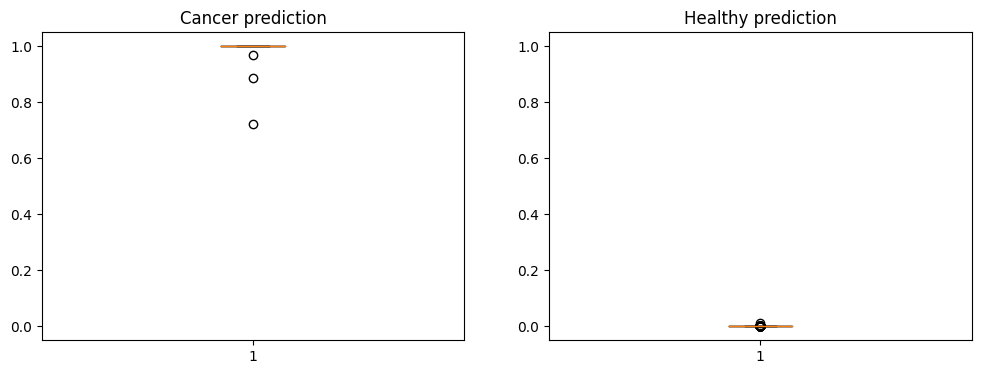

In [10]:
vis = Visualisation(lgbm_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

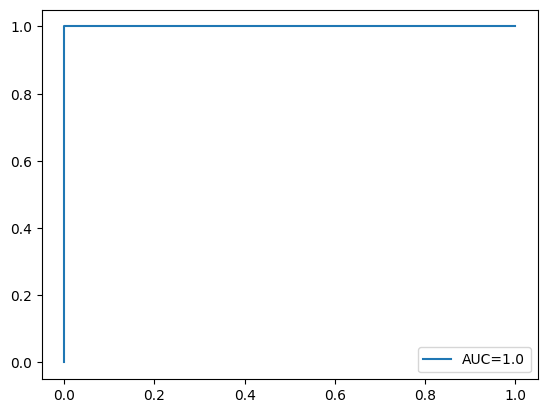

In [11]:
vis.draw_roc_curve_from_probabilities()

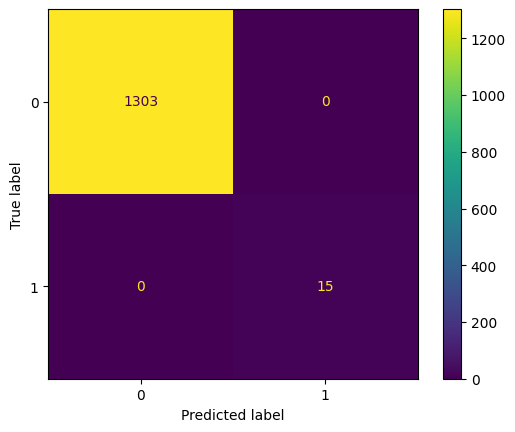

In [12]:
vis.display_confusion_matrix()

In [13]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(lgbm_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 155


In [14]:
lgbm_model_object = Model(
    lgbm_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9015151515151515
Training balanced accuracy 1.0

Validation roc auc 0.9999700858536001
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.8030303030303031
Training recall 1.0

Validation f1 0.8730158730158729
Training f1 1.0



In [15]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.9888888888888889

Test roc auc 1.0

Test precision 1.0

Test recall 0.9777777777777779

Test f1 score 0.9885057471264368


### Cut by mean with classes

In [16]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9442799166392453
Training balanced accuracy 1.0

Validation roc auc 0.9999700858536001
Training roc auc 1.0

Validation precision 0.9722222222222222
Training precision 1.0

Validation recall 0.8888888888888888
Training recall 1.0

Validation f1 0.918840579710145
Training f1 1.0



In [17]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.9555555555555556

Test roc auc 1.0

Test precision 1.0

Test recall 0.9111111111111111

Test f1 score 0.9523809523809524


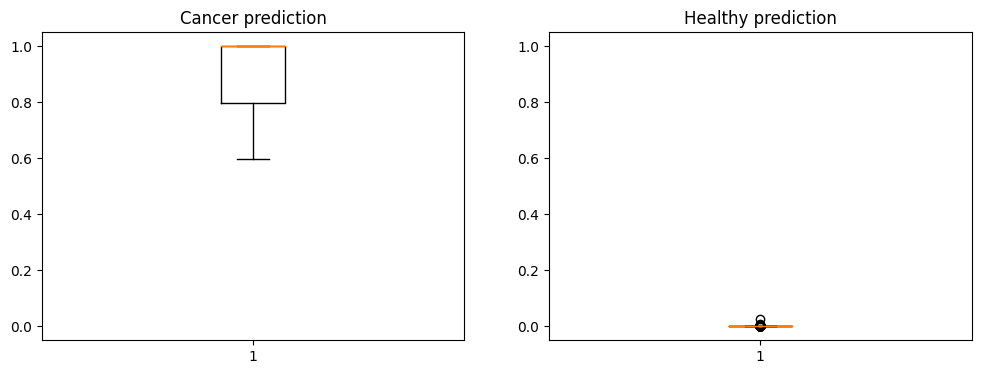

In [18]:
vis = Visualisation(lgbm_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

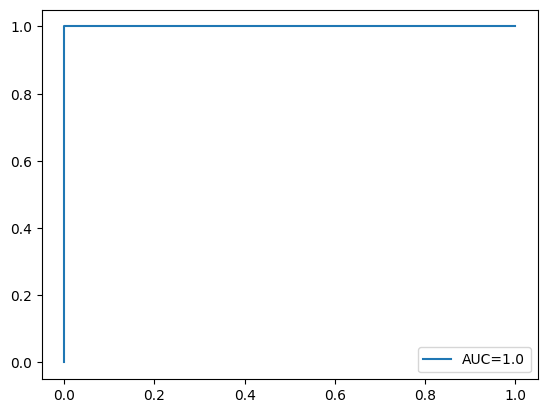

In [19]:
vis.draw_roc_curve_from_probabilities()

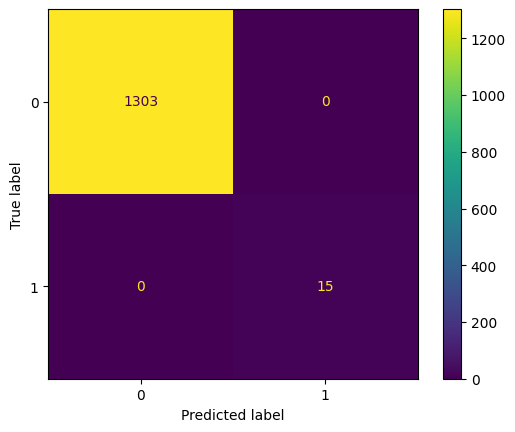

In [20]:
vis.display_confusion_matrix()

In [21]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(lgbm_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 114


In [22]:
lgbm_model_object = Model(
    lgbm_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9442799166392453
Training balanced accuracy 1.0

Validation roc auc 0.9999700858536001
Training roc auc 1.0

Validation precision 0.9722222222222222
Training precision 1.0

Validation recall 0.8888888888888888
Training recall 1.0

Validation f1 0.918840579710145
Training f1 1.0



In [23]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.9555555555555556

Test roc auc 1.0

Test precision 1.0

Test recall 0.9111111111111111

Test f1 score 0.9523809523809524


### XGBoost

In [24]:
healthy_cells_train_indices = np.where(data_object.train_true_results == 0)[0]
cancer_cells_train_indices = np.where(data_object.train_true_results == 1)[0]

class_weight = len(healthy_cells_train_indices) / len(cancer_cells_train_indices)

xgb_clf = XGBClassifier(
    booster="gbtree",
    eta=0.2,
    min_child_weight=48,
    max_depth=8,
    gamma=0.01,   
    scale_pos_weight=class_weight,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [25]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9995064165844028
Training balanced accuracy 0.9999177360974004

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.9333333333333332
Training precision 0.9861111111111112

Validation recall 1.0
Training recall 1.0

Validation f1 0.9629629629629629
Training f1 0.9929078014184397



In [26]:
xgboost_model_object.display_test_results()

Test balanced accuracy 1.0

Test roc auc 1.0

Test precision 1.0

Test recall 1.0

Test f1 score 1.0


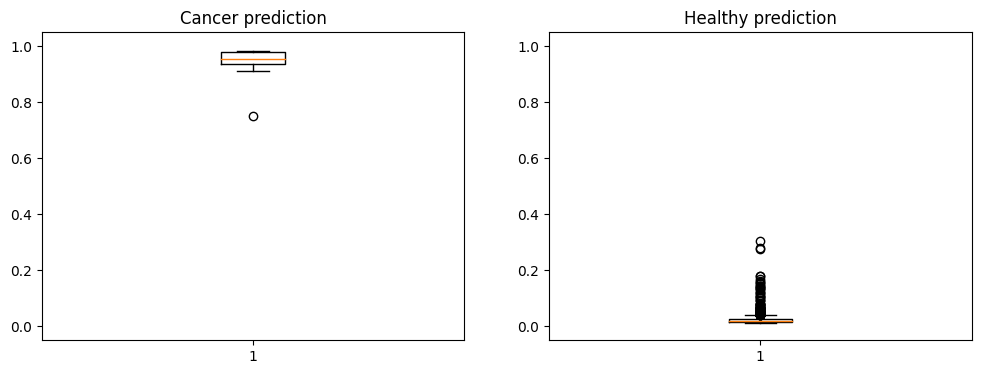

In [27]:
vis = Visualisation(xgboost_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

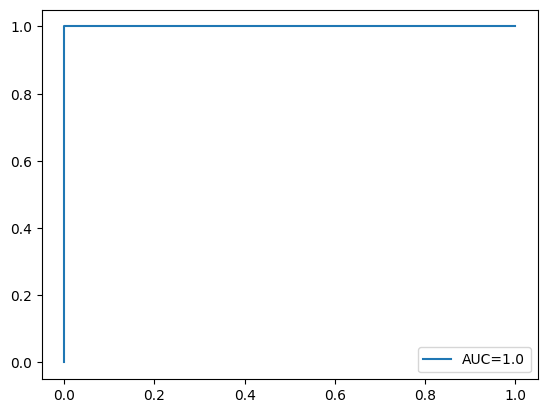

In [28]:
vis.draw_roc_curve_from_probabilities()

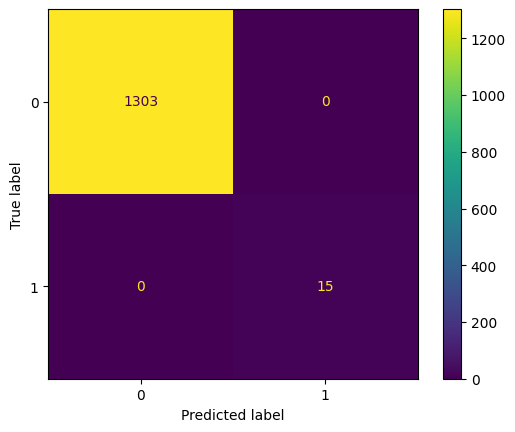

In [29]:
vis.display_confusion_matrix()

In [30]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(xgboost_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 22


In [31]:
xgboost_model_object = Model(
    xgb_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9995064165844028
Training balanced accuracy 0.9999177360974004

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.9333333333333332
Training precision 0.9861111111111112

Validation recall 1.0
Training recall 1.0

Validation f1 0.9629629629629629
Training f1 0.9929078014184397



In [32]:
xgboost_model_object.display_test_results()

Test balanced accuracy 1.0

Test roc auc 1.0

Test precision 1.0

Test recall 1.0

Test f1 score 1.0


### Cut by mean with classes

In [33]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9852884720851156
Training balanced accuracy 0.9997532082922014

Validation roc auc 0.9999451573982668
Training roc auc 1.0

Validation precision 0.8751526251526252
Training precision 0.9615384615384616

Validation recall 0.9722222222222222
Training recall 1.0

Validation f1 0.918888888888889
Training f1 0.9795918367346937



In [34]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9878656092777351

Test roc auc 0.9999658906796283

Test precision 0.865546218487395

Test recall 0.9777777777777779

Test f1 score 0.9121168582375478


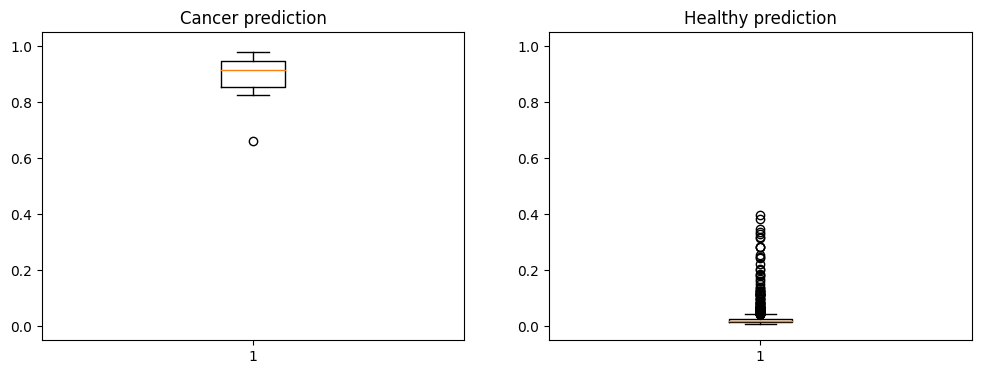

In [35]:
vis = Visualisation(xgboost_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

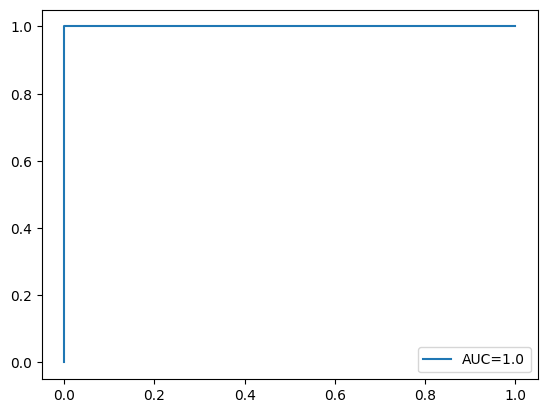

In [36]:
vis.draw_roc_curve_from_probabilities()

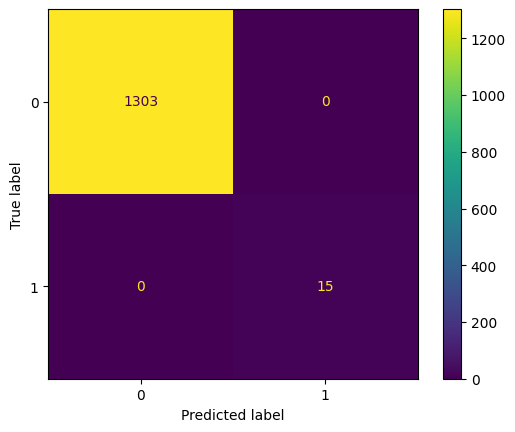

In [37]:
vis.display_confusion_matrix()

In [38]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(xgboost_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 39


In [39]:
xgboost_model_object = Model(
    xgb_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9852884720851156
Training balanced accuracy 0.9997532082922014

Validation roc auc 0.9999451573982668
Training roc auc 1.0

Validation precision 0.8751526251526252
Training precision 0.9615384615384616

Validation recall 0.9722222222222222
Training recall 1.0

Validation f1 0.918888888888889
Training f1 0.9795918367346937



In [40]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.9878656092777351

Test roc auc 0.9999658906796283

Test precision 0.865546218487395

Test recall 0.9777777777777779

Test f1 score 0.9121168582375478


### Random Forest

In [41]:
rf_clf = RandomForestClassifier(  
    criterion="log_loss",
    n_estimators=2000,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [42]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9305555555555557
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.8611111111111112
Training recall 1.0

Validation f1 0.912280701754386
Training f1 1.0



In [43]:
rf_model_object.display_test_results()

Test balanced accuracy 0.9777777777777779

Test roc auc 1.0

Test precision 1.0

Test recall 0.9555555555555556

Test f1 score 0.9761904761904763


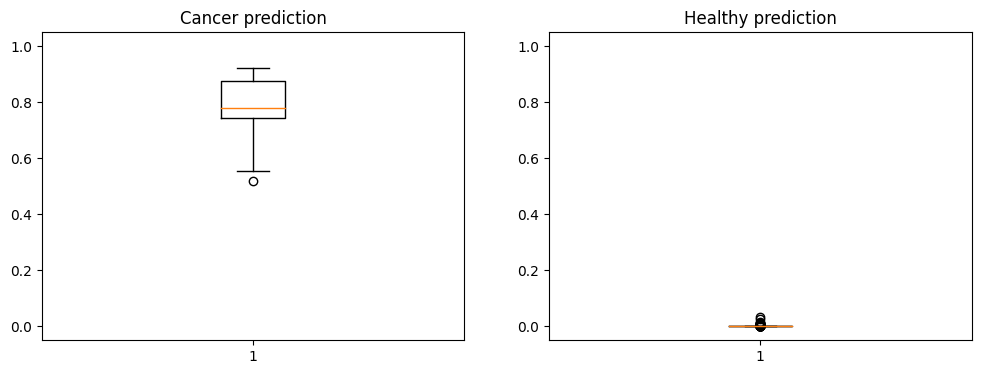

In [44]:
vis = Visualisation(rf_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

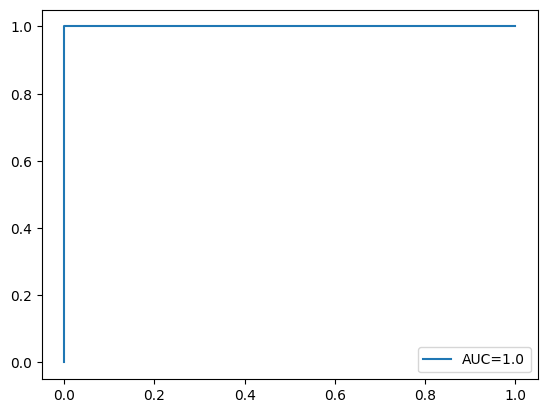

In [45]:
vis.draw_roc_curve_from_probabilities()

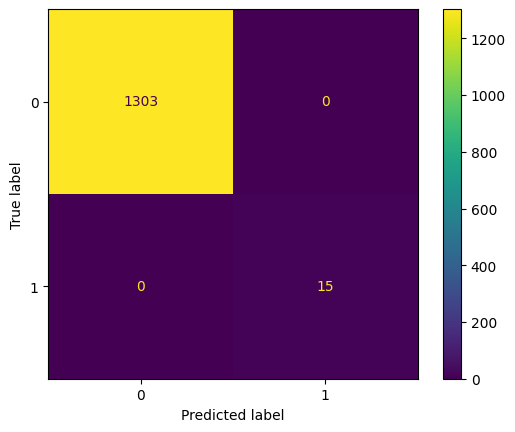

In [46]:
vis.display_confusion_matrix()

In [47]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(rf_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 177


In [48]:
rf_model_object = Model(
    rf_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9305555555555557
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.8611111111111112
Training recall 1.0

Validation f1 0.912280701754386
Training f1 1.0



In [49]:
rf_model_object.display_test_results()

Test balanced accuracy 0.9777777777777779

Test roc auc 1.0

Test precision 1.0

Test recall 0.9555555555555556

Test f1 score 0.9761904761904763


### Cut by mean with classes

In [50]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.8320707070707071
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.664141414141414
Training recall 1.0

Validation f1 0.780205415499533
Training f1 1.0



In [51]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8777777777777778

Test roc auc 1.0

Test precision 1.0

Test recall 0.7555555555555555

Test f1 score 0.8603988603988603


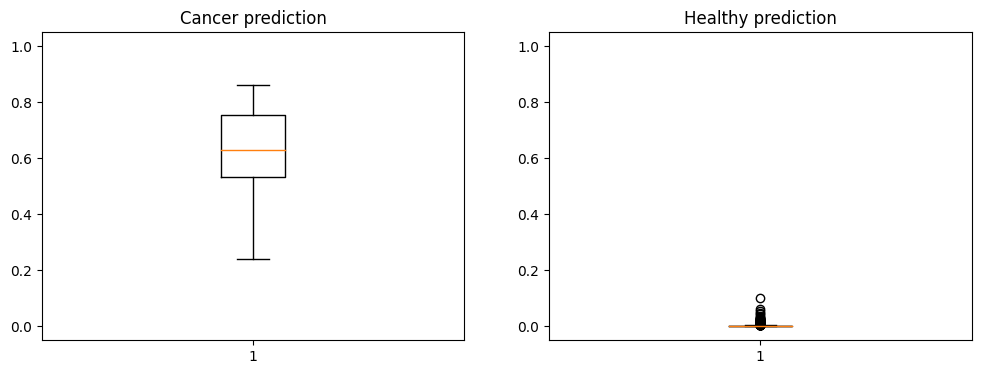

In [52]:
vis = Visualisation(rf_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

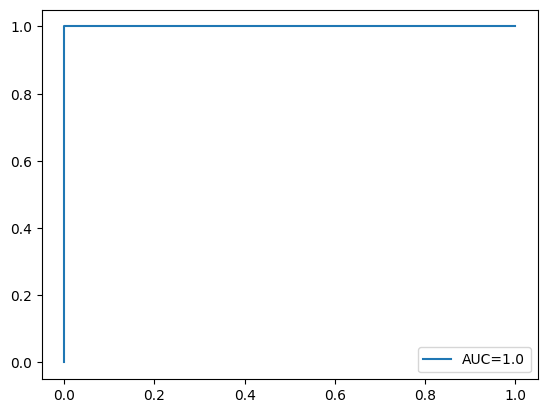

In [53]:
vis.draw_roc_curve_from_probabilities()

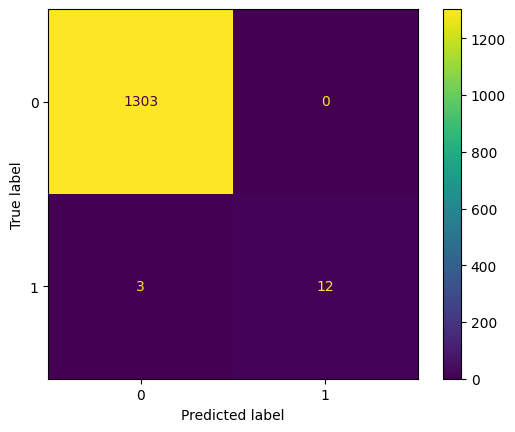

In [54]:
vis.display_confusion_matrix()

In [55]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(rf_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 119


In [56]:
rf_model_object = Model(
    rf_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.8320707070707071
Training balanced accuracy 1.0

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 1.0
Training precision 1.0

Validation recall 0.664141414141414
Training recall 1.0

Validation f1 0.780205415499533
Training f1 1.0



In [57]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8777777777777778

Test roc auc 1.0

Test precision 1.0

Test recall 0.7555555555555555

Test f1 score 0.8603988603988603


### Balanced Random Forest

In [58]:
brf_clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    class_weight="balanced",
    criterion="entropy",
    oob_score=True,  
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [59]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_max_train_data,
    data_object.train_true_results,
    cut_by_mean_max_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9993418887792037
Training balanced accuracy 0.9991773609740046

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.9076923076923077
Training precision 0.8754578754578755

Validation recall 1.0
Training recall 1.0

Validation f1 0.9496296296296297
Training f1 0.933542647828362



In [60]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9993604502430289

Test roc auc 0.9999829453398141

Test precision 0.9027777777777778

Test recall 1.0

Test f1 score 0.9481915933528837


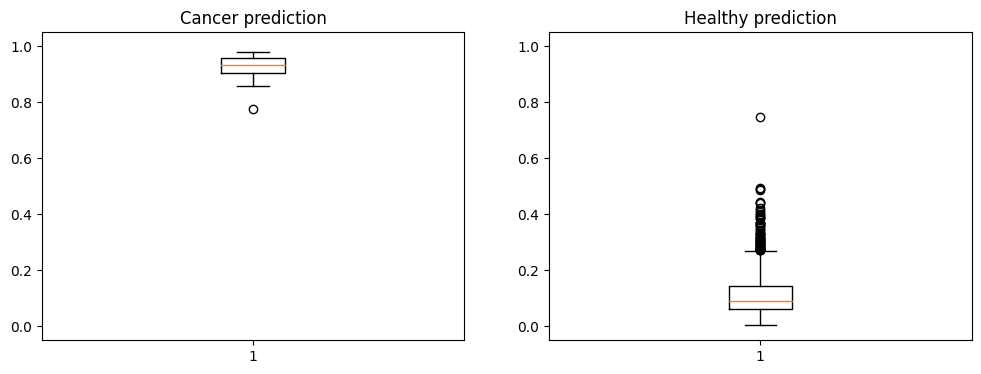

In [61]:
vis = Visualisation(brf_estimators, cut_by_mean_max_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

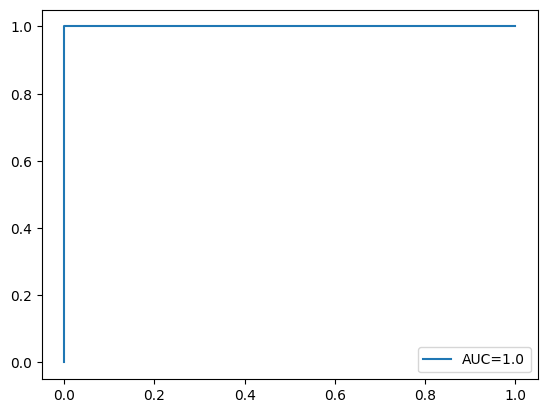

In [62]:
vis.draw_roc_curve_from_probabilities()

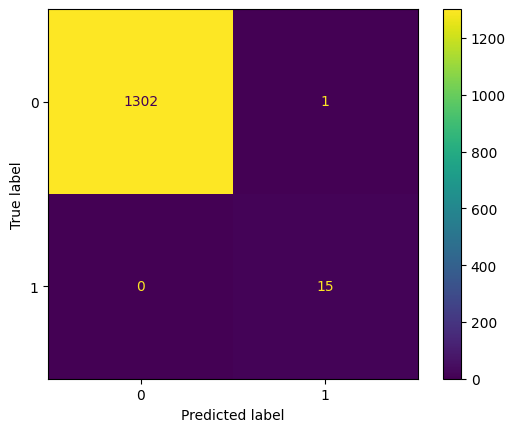

In [63]:
vis.display_confusion_matrix()

In [64]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(brf_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 177


In [65]:
brf_model_object = Model(
    brf_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9993418887792037
Training balanced accuracy 0.9991773609740046

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.9076923076923077
Training precision 0.8754578754578755

Validation recall 1.0
Training recall 1.0

Validation f1 0.9496296296296297
Training f1 0.933542647828362



In [66]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9993604502430289

Test roc auc 0.9999829453398141

Test precision 0.9027777777777778

Test recall 1.0

Test f1 score 0.9481915933528837


### Cut by mean with classes

In [67]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_true_results,
    cut_by_mean_with_classes_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9973675551168147
Training balanced accuracy 0.9974498190194142

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.6889978213507626
Training precision 0.6995530012771392

Validation recall 1.0
Training recall 1.0

Validation f1 0.8144499178981938
Training f1 0.821425467188179



In [68]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9964185213609619

Test roc auc 0.9998635627185127

Test precision 0.6232804232804233

Test recall 1.0

Test f1 score 0.7658730158730158


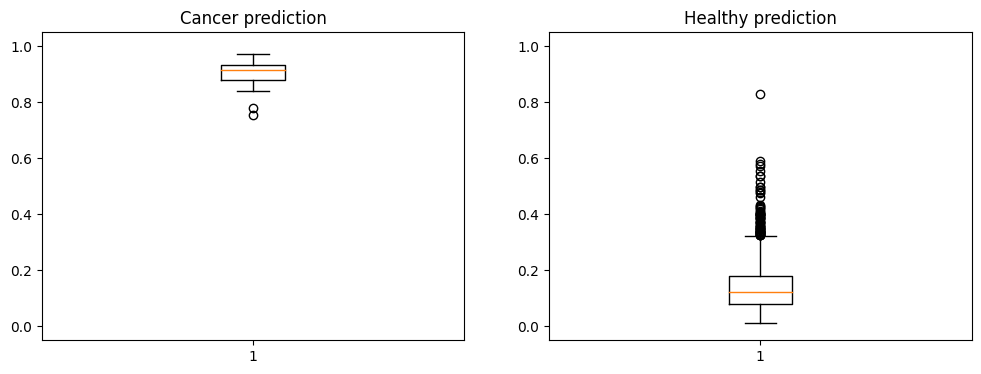

In [69]:
vis = Visualisation(brf_estimators, cut_by_mean_with_classes_test_data, data_object.test_true_results)
vis.plot_predictions_boxplot()

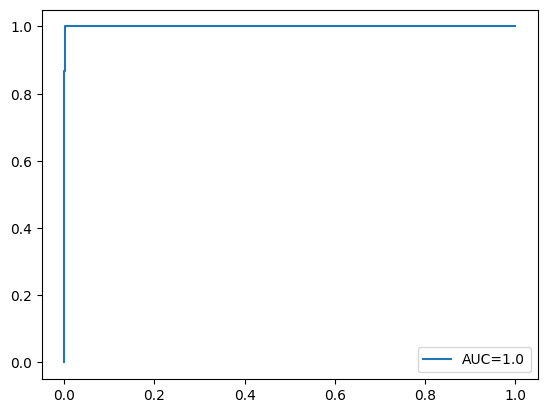

In [70]:
vis.draw_roc_curve_from_probabilities()

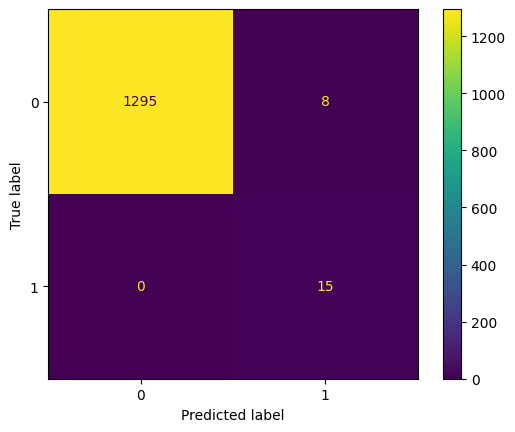

In [71]:
vis.display_confusion_matrix()

In [72]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(brf_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 119


In [73]:
brf_model_object = Model(
    brf_clf,
    reduced_train_data,
    data_object.train_true_results,
    reduced_test_data,
    data_object.test_true_results,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9973675551168147
Training balanced accuracy 0.9974498190194142

Validation roc auc 1.0
Training roc auc 1.0

Validation precision 0.6889978213507626
Training precision 0.6995530012771392

Validation recall 1.0
Training recall 1.0

Validation f1 0.8144499178981938
Training f1 0.821425467188179



In [74]:
brf_model_object.display_test_results()

Test balanced accuracy 0.9964185213609619

Test roc auc 0.9998635627185127

Test precision 0.6232804232804233

Test recall 1.0

Test f1 score 0.7658730158730158
